
|평가문항|상세기준|
|:--|:--|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 구축

In [10]:
(ds_train, ds_val, ds_test), info = tfds.load(
    'stanford_dogs',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [5]:
#train, val, test 개수 확인
len(ds_train),len(ds_val),len(ds_test)

(10800, 1200, 8580)

In [4]:
# class 확인
num_classes = info.features["label"].num_classes
num_classes

120

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
#     print('augment')
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def augment2(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_contrast(image, 1/1.3, 1.3)
    image = tf.image.random_hue(image, 0.1)
#     image = tf.keras.preprocessing.image.random_rotation(image, 90)

#     random_height = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     random_width = tf.random.uniform((), minval=32, maxval=40, dtype=tf.int32)
#     image = tf.image.resize(image, (random_height, random_width))
#     image = tf.image.random_crop(image, (32, 32, 3))
    return image, label

### 전처리

In [9]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # 일반 aug 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    
    # cutmix, mixup은 batch 후에 적용
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup 적용
    elif not is_test and with_mixup:  
        ds = ds.map(
            mixup,
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
            
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_val = apply_normalize_on_dataset(ds_val, is_test=False)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### CutMix

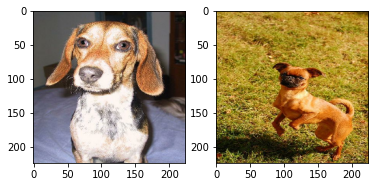

In [12]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [13]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(70, shape=(), dtype=int32) tf.Tensor(210, shape=(), dtype=int32)
y :  tf.Tensor(131, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


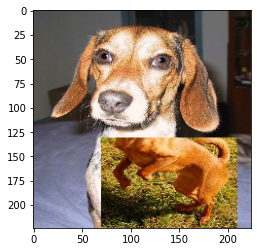

In [14]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [15]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.7405134 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [16]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

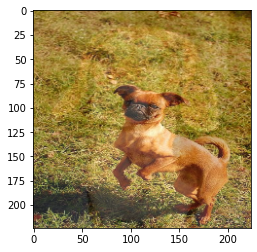

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.22270966
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [17]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [18]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 모델 구축

In [20]:
EPOCH = 20 

### (1) Resnet-50

In [24]:
import pickle

### (3) Resnet-50 with cutmix

In [30]:
ds_train_cm = apply_normalize_on_dataset(ds_train, with_cutmix=True)

In [31]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cm = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 173s 220ms/step - loss: 2.8439 - accuracy: 0.3074 - val_loss: 2.8331 - val_accuracy: 0.2833
Epoch 2/20
750/750 [==============================] - 160s 214ms/step - loss: 1.5211 - accuracy: 0.5689 - val_loss: 1.5465 - val_accuracy: 0.5421
Epoch 3/20
119/750 [===>..........................] - ETA: 1:49 - loss: 1.1846 - accuracy: 0.6644

KeyboardInterrupt: 

In [ ]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_cm.hdf5')

print('Resnet-50 with Cutmix')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_cm.pickle','wb') as f:
    pickle.dump(history_resnet50_cm.history,f)
    
del history_resnet50_cm
del resnet50

### (4) Resnet-50 with mixup

In [46]:
ds_train_mu = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cm = resnet50.fit(
    ds_train_mu, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(info.splits['train'].num_examples/16),
    validation_steps=int(info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
del ds_train_aug
loss, accuracy = resnet50.evaluate(ds_test)
resnet50.save('resnet50_cm.hdf5')

print('Resnet-50 with Cutmix')
print(f"Loss: {loss},\nAccuracy: {accuracy}")

with open('history_resnet50_cm.pickle','wb') as f:
    pickle.dump(history_resnet50_cm.history,f)
    
del history_resnet50_cm
del resnet50

### 결과 비교 분석

In [ ]:
with open('history_resnet50_no_aug.pickle', 'rb') as f:
    history_resnet50_no_aug = pickle.load(f) 
with open('history_resnet50_aug.pickle', 'rb') as f:
    history_resnet50_aug = pickle.load(f) 
with open('history_resnet50_cm.pickle', 'rb') as f:
    history_resnet50_cm = pickle.load(f) 
with open('history_resnet50_mu.pickle', 'rb') as f:
    history_resnet50_mu = pickle.load(f) 

In [ ]:
histories = [
    history_resnet50_no_aug
    history_resnet50_aug,
    history_resnet50_cm,
    history_resnet50_mu,
]

In [ ]:
names = ['Resnet-50','w.Aug','w.CutMix','w.MixUp']

In [ ]:
def show_log(metric, hitories, names, each = False, valid = True):
    if each :
        fig, ax = plt.subplots(1,4, figsize=(15,15))
        ax[0].plot(range(len(histories[0].history[metric])), history1.history[metric], label = names[0])
        ax[0].plot(range(len(histories[0].history['val_'+metric])), history1.history['val_'+metric], label = names[0])
        ax[1].plot(range(len(histories[1].history[metric])), history2.history[metric], label = names[1])
        ax[1].plot(range(len(histories[1].history['val_'+metric])), history2.history['val_'+metric], label = names[1])
        ax[2].plot(range(len(histories[2].history[metric])), history1.history[metric], label = names[2])
        ax[2].plot(range(len(histories[2].history['val_'+metric])), history1.history['val_'+metric], label = names[2])
        ax[3].plot(range(len(histories[3].history[metric])), history2.history[metric], label = names[3])
        ax[3].plot(range(len(histories[3].history['val_'+metric])), history2.history['val_'+metric], label = names[3])
        plt.title(f'Training log: {metric}')
    else :
        plt.figure(figsize=(15,15))
        plt.plot(range(len(histories[0].history[metric])), history1.history[metric], label = names[0])
        plt.plot(range(len(histories[1].history[metric])), history2.history[metric], label = names[1])
        plt.plot(range(len(histories[2].history[metric])), history1.history[metric], label = names[2])
        plt.plot(range(len(histories[3].history[metric])), history2.history[metric], label = names[3])
        plt.title(f'Training log: {metric}')
        if valid:
            plt.plot(range(len(histories[0].history['val_'+metric])), history1.history['val_'+metric], label = 'val_'+names[0])
            plt.plot(range(len(histories[1].history['val_'+metric])), history2.history['val_'+metric], label = 'val_'+names[1])
            plt.plot(range(len(histories[2].history['val_'+metric])), history1.history['val_'+metric], label = 'val_'+names[2])
            plt.plot(range(len(histories[3].history['val_'+metric])), history2.history['val_'+metric], label = 'val_'+names[3])
       
    plt.show()


def Show_val_log(history1, history2 , names, valid = True):
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].plot(range(len(history1.history['loss'])), history1.history['loss'], label = names[0])
    ax[0].plot(range(len(history2.history['loss'])), history2.history['loss'], label = names[1])
    
    ax[0].plot(range(len(history1.history['val_loss'])), history1.history['val_loss'], label = names[0])
    ax[0].plot(range(len(history2.history['val_loss'])), history2.history['val_loss'], label = names[1])
    ax[0].set_title('Validation Loss')
    ax[0].legend()

    ax[1].plot(range(len(history1.history['accuracy'])),history1.history['val_accuracy'], label = names[0])
    ax[1].plot(range(len(history2.history['accuracy'])),history2.history['val_accuracy'], label = names[1])
    ax[1].set_title('Validation Accuracy')
    ax[1].legend()

    plt.show()

In [ ]:
show_log('accuracy',hitories, names)

In [ ]:
show_log('loss',hitories, names)

In [ ]:
show_log('loss',hitories, names, each = True)